In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import validation_curve

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
# some notes about the attributes:
#
# *The labeling of multiple categorical attrubutes from the UCI website is different from the Kaggle website
# *there are: cp, slope, and thal
#
# Categorical Factors:
# age: age in years
# sex: (1 = male; 0 = female)
# cp: chest pain type, (1: typical angina; 
#                       2: atypical angina; 
#                       3: non-anginal pain; 
#                       4: asymptomatic)    #0,1,2,3?
# fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
# restecg: resting electrocardiographic results, 
#         (0: normal, 
#          1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV),
#          2: showing probable or definite left ventricular hypertrophy by Estes' criteria)
# exang: exercise induced angina (1 = yes; 0 = no)
# slope: the slope of the peak exercise ST segment
#       (1: upsloping
#        2: flat
#        3: downsloping)    #0,1,2?
# ca: number of major vessels (0-3) colored by flourosopy
# thal: 3 = normal; 6 = fixed defect; 7 = reversable defect    #1,2,3?
#
# Numeric Factors:
# age: age in years
# trestbps: resting blood pressure (in mm Hg on admission to the hospital)
# chol: serum cholestoral in mg/dl
# thalach: maximum heart rate achieved
# oldpeak: ST depression induced by exercise relative to rest
# 
# Dependent Variable:
# target: diagnosis of heart disease (angiographic disease status)
#        (0: < 50% diameter narrowing
#         1: > 50% diameter narrowing)

In [4]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [5]:
df.info()  ##turns out no NaN values, but still need to check for other invalid values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


# Data Cleaning

In [6]:
# a function to detect invalid entries
# takes a row in the dataframe
# returns a boolean variable, True for valid data, False for invalid data
# it could print a better explained message, but I think the short version is fine for now.
def CheckValid(row):
    #first check numeric variables
    if row['age'] < 0 :
        print('invalid age')
        return False
    elif row['trestbps'] < 0:
        print('invalid trestbps')
        return False
    elif row['chol'] < 0:
        print('invalid chol')
        return False
    elif row['thalach'] < 0:
        print('invalid thalach')
        return False
    elif row['oldpeak'] < 0:
        print('invalid oldpeak')
        return False
    #then check categorical variables
    elif row['sex'] not in [0,1]:
        print('invalid sex')
        return False
    elif row['cp'] not in [0,1,2,3]:
        print('invalid cp')
        return False
    elif row['fbs'] not in [0,1]:
        print('invalid fbs')
        return False
    elif row['restecg'] not in [0,1,2]:
        print('invalid restecg')
        return False
    elif row['exang'] not in [0,1]:
        print('invalid exang')
        return False
    elif row['slope'] not in [0,1,2]:
        print('invalid slope')
        return False
    elif row['ca'] not in [0,1,2,3]:
        print('invalid ca')
        print(row['ca'])
        return False
    elif row['thal'] not in [1,2,3]:
        print('invalid thal')
        return False
    elif row['target'] not in [0,1]:
        print('invalid target')
        return False
        
    return True


In [7]:
remove_list = []

#traverse rows in dataframe to check if valid
for i in range(len(df)):
    if not CheckValid(df.loc[i]):
        remove_list.append(i)
        
print(remove_list)

invalid thal
invalid ca
4.0
invalid ca
4.0
invalid ca
4.0
invalid ca
4.0
invalid ca
4.0
invalid thal
[48, 92, 158, 163, 164, 251, 281]


In [8]:
# remove invalid datas
df_cleaned = df.drop(remove_list)

In [9]:
df_cleaned   # 296 valid data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# Outlier detection

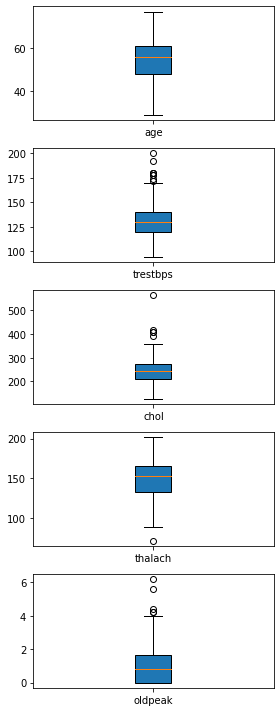

In [10]:
non_categ = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
# print(list(df_cleaned.columns).index(col)+1)
fig, a = plt.subplots(5, 1, figsize=(4,10))
idx = 0

for col in df_cleaned[non_categ]: 
    a[idx].boxplot(df_cleaned[col], patch_artist=True, labels = [col])
    a[idx].set_aspect('auto')
    idx = idx + 1
    
plt.tight_layout()
plt.show()

There are a lot of outliers in oldpeak and chol, which won't be useful for training our model. Right now I've used IsolationForest which seems to work fine:

In [11]:
data_cpy = df_cleaned[non_categ].copy()
detector = IsolationForest(n_jobs=-1)
predicted = detector.fit_predict(data_cpy)

print("Isolation Forest:")
print(pd.crosstab(predicted, columns=['count']))

if_outcome = np.where(predicted == -1)
df_cleaned_if = df_cleaned.drop(df_cleaned.index[if_outcome[0]])

Isolation Forest:
col_0  count
row_0       
-1        38
 1       258


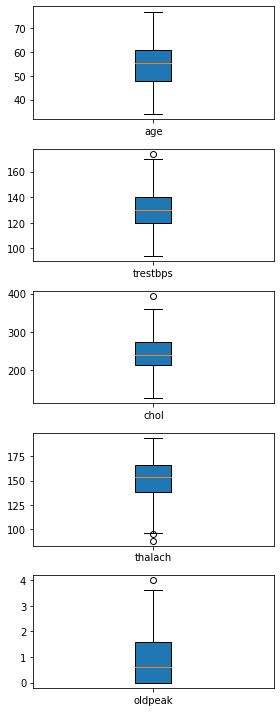

In [12]:
fig, a = plt.subplots(5, 1, figsize=(4,10))
idx = 0

for col in df_cleaned_if[non_categ]: 
    a[idx].boxplot(df_cleaned_if[col], patch_artist=True, labels = [col])
    a[idx].set_aspect('auto')
    idx = idx + 1
    
plt.tight_layout()
plt.show()

In [13]:
detector = LocalOutlierFactor(n_jobs = -1)
predicted = detector.fit_predict(data_cpy)

print("Local Outlier Factor:")
print(pd.crosstab(predicted, columns=['count']))

lof_outcome = np.where(predicted == -1)
df_cleaned_lof = df_cleaned.drop(df_cleaned.index[lof_outcome[0]])

Local Outlier Factor:
col_0  count
row_0       
-1        10
 1       286


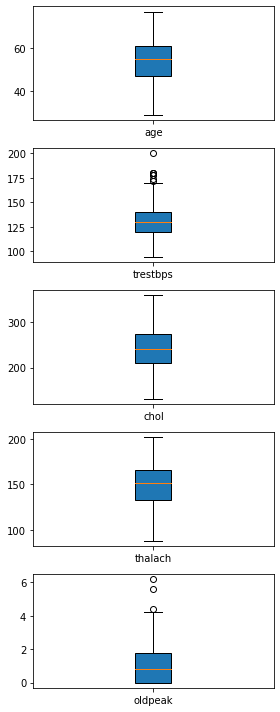

In [14]:
fig, a = plt.subplots(5, 1, figsize=(4,10))
idx = 0

for col in df_cleaned_lof[non_categ]: 
    a[idx].boxplot(df_cleaned_lof[col], patch_artist=True, labels = [col])
    a[idx].set_aspect('auto')
    idx = idx + 1
    
plt.tight_layout()
plt.show()

In [15]:
print("Size of intersection for lof and if: ", len(np.intersect1d(lof_outcome, if_outcome)))

Size of intersection for lof and if:  8


In [16]:
df_cleaned = df_cleaned_if
# currently choosing to stick to isolation forest

# Normalizing Numerical Data

In [17]:
numerical_features = df_cleaned.select_dtypes(['int64', 'float64']).columns.values

#normalize numerical
from sklearn.preprocessing import MinMaxScaler

numerical_transform = MinMaxScaler()
numerical_processed = numerical_transform.fit_transform(df_cleaned[numerical_features])

df_cleaned.update(pd.DataFrame(numerical_processed, columns = numerical_features))
df_cleaned.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.674419,1.0,1.000000,0.6375,0.399254,1.0,0.0,0.584906,0.0,0.575,0.0,0.0,0.0,1.0
2,0.511628,1.0,0.333333,0.3250,0.410448,0.0,0.5,0.849057,0.0,0.200,1.0,0.0,0.5,1.0
3,0.534884,0.0,0.000000,0.3250,0.850746,0.0,0.5,0.707547,1.0,0.150,1.0,0.0,0.5,1.0
4,0.534884,1.0,0.000000,0.5750,0.246269,0.0,0.5,0.566038,0.0,0.100,0.5,0.0,0.0,1.0
5,0.511628,0.0,0.333333,0.5750,0.626866,0.0,0.0,0.613208,0.0,0.325,0.5,0.0,0.5,1.0


# Output Cleaned Data to a csv file

In [42]:
df_cleaned.to_csv('ECS171_Project_CleanedData.csv', index = False)



# Basic EDA

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>],
       [<AxesSubplot:title={'center':'cp'}>,
        <AxesSubplot:title={'center':'trestbps'}>],
       [<AxesSubplot:title={'center':'chol'}>,
        <AxesSubplot:title={'center':'fbs'}>],
       [<AxesSubplot:title={'center':'restecg'}>,
        <AxesSubplot:title={'center':'thalach'}>],
       [<AxesSubplot:title={'center':'exang'}>,
        <AxesSubplot:title={'center':'oldpeak'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'ca'}>],
       [<AxesSubplot:title={'center':'thal'}>,
        <AxesSubplot:title={'center':'target'}>]], dtype=object)

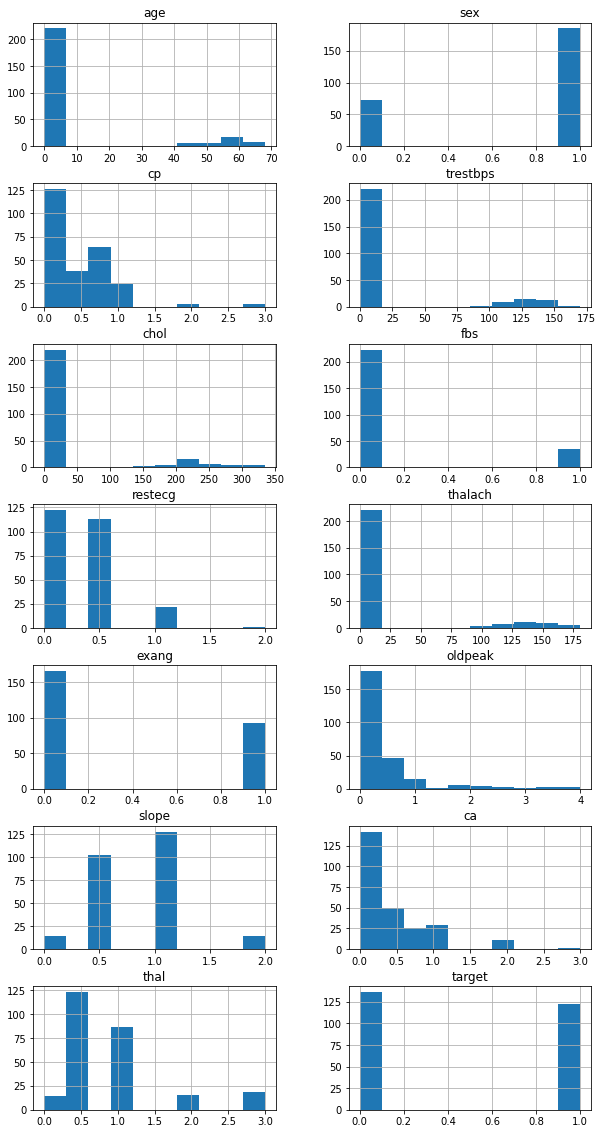

In [18]:
df_cleaned.hist(figsize=(10,20), layout=(7,2))

# EDA Visualization (might be useful for project demo slides)

In [19]:
#extract data with >50% of getting heart diease, aka target==1
df_high_risk = df[df['target'] == 1]

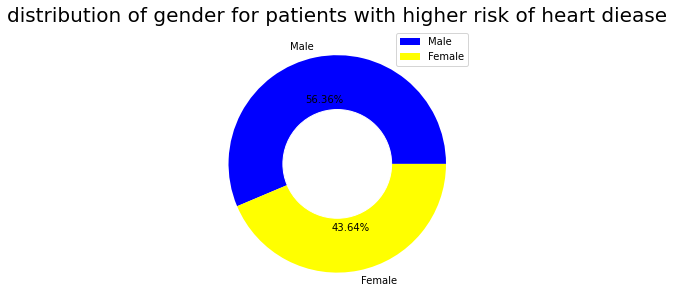

In [20]:
circle = plt.Circle((0, 0), 0.5, color = 'white')

plt.rcParams['figure.figsize'] = (5, 5)
plt.pie(df_high_risk['sex'].value_counts(), colors = ['blue', 'yellow'], labels = ["Male", "Female"], autopct = '%.2f%%')
plt.title('distribution of gender for patients with higher risk of heart diease', fontsize = 20)
plt.gcf().gca().add_artist(circle)
plt.legend()
plt.show()

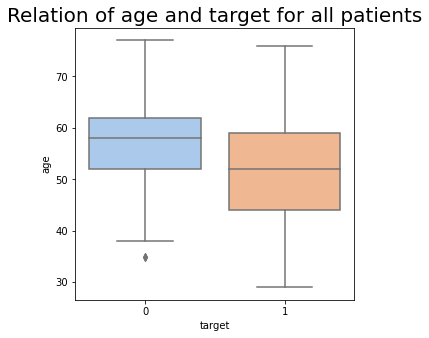

In [21]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.boxplot(x=df['target'], y=df['age'], palette = 'pastel')
plt.title('Relation of age and target for all patients', fontsize = 20)
plt.show()

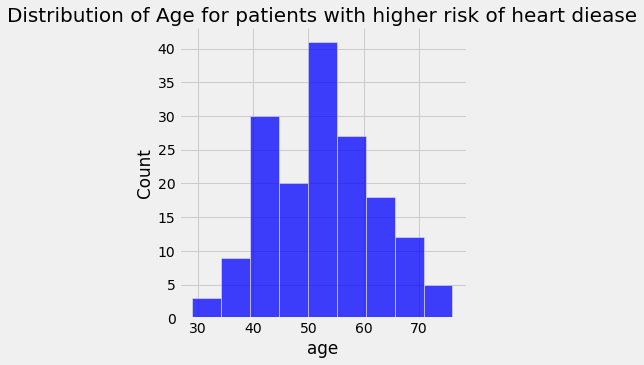

In [22]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (5, 5)
sns.displot(df_high_risk['age'], color = 'blue')
plt.title('Distribution of Age for patients with higher risk of heart diease', fontsize = 20)
plt.show()

<AxesSubplot:>

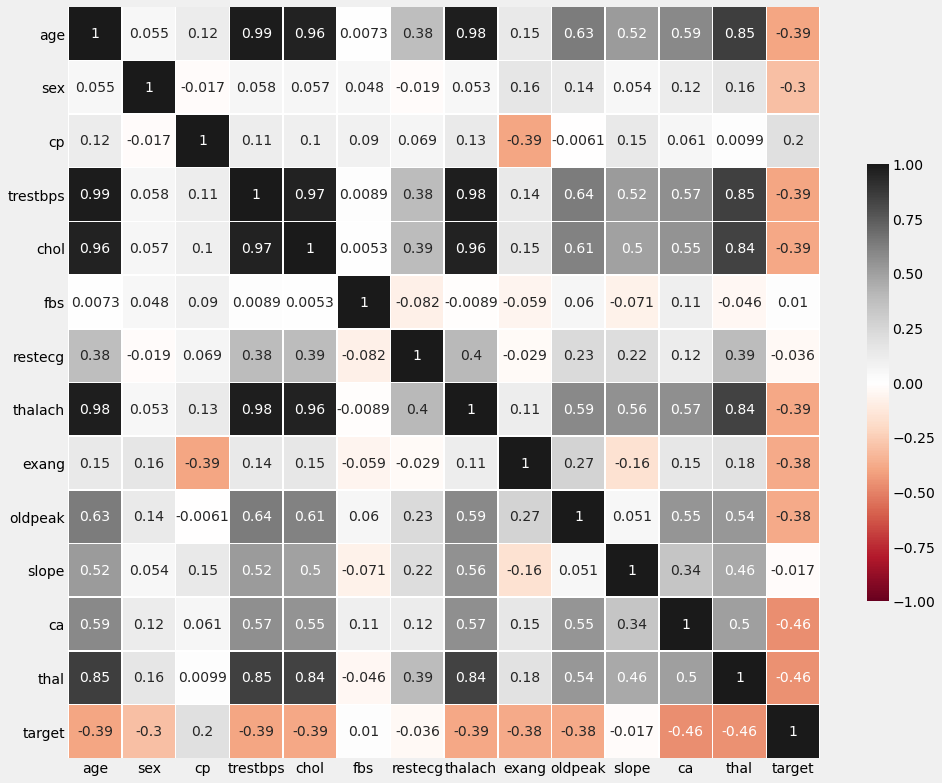

In [23]:
# correlation matrix for numeric variables
plt.figure(figsize = (15,15))
sns.heatmap(df_cleaned.corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='RdGy',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [24]:
df_cleaned.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.674419,1.0,1.000000,0.6375,0.399254,1.0,0.0,0.584906,0.0,0.575,0.0,0.0,0.0,1.0
2,0.511628,1.0,0.333333,0.3250,0.410448,0.0,0.5,0.849057,0.0,0.200,1.0,0.0,0.5,1.0
3,0.534884,0.0,0.000000,0.3250,0.850746,0.0,0.5,0.707547,1.0,0.150,1.0,0.0,0.5,1.0


# Output Clean Data to a CSV file

In [25]:
df_cleaned.to_csv('ECS171_Project_CleanedData.csv', index = False)

# Here starts the analysis of the data

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


In [27]:
age_user=0
sex_user=0	
cp_user=0
trestbps_user=0	
chol_user=0
fbs_user=0
restecg_user=0
thalach_user=0
exang_user=0
oldpeak_user=0
slope_user=0
ca_user=0
thal_user=0
user_data=[age_user,sex_user,cp_user,trestbps_user,chol_user,fbs_user,restecg_user,thalach_user,exang_user,oldpeak_user,slope_user,ca_user,thal_user]

In [28]:
X = df_cleaned.drop(['target'], axis=1)
Y = df_cleaned['target']

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3)

# x_training, x_testing, y_train, y_test = train_test_split(X,Y, test_size=0.3)
# sc = StandardScaler()
# x_train = sc.fit_transform(x_training)
# x_test = sc.transform(x_testing)

In [41]:
log = LogisticRegression(max_iter=20000)
log.fit(x_train, y_train)
print("weights:")
for i in range(0, len(log.coef_[0])):
    print("b{}: {}".format(i, log.coef_[0][i]))
#print("weights: {}".format(log.coef_[0]))
print("bias{}: {}".format(0, log.intercept_[0]))
y_predict = log.predict(x_test)

print("mse: {}".format(mean_squared_error(y_test, y_predict)))

log_pre = precision_score(np.array(y_test).reshape(-1,1),y_predict,average="macro",zero_division=0)
log_recall = recall_score(y_test,y_predict,average="macro",zero_division=0)

print("log precision: {}\n   log recall: {}".format(log_pre, log_recall))
user_predict=log.predict(np.array(user_data).reshape(1,-1))



# weights here are actually from b1 to b13, -0.6843 is not the bias

weights:
b0: -0.4551906643702838
b1: -1.3587094504197657
b2: 1.0809341266671801
b3: -0.6893957340396839
b4: -0.5137188500280933
b5: 0.39418777205991073
b6: 0.657977926610614
b7: 1.2943087677756941
b8: -0.6096411963518741
b9: -1.2682703578177237
b10: 0.8946749943399364
b11: -1.745130807614034
b12: -1.4792676276786356
bias0: 1.6940988333641411
mse: 0.11538461538461539
log precision: 0.8848684210526316
   log recall: 0.8846153846153846


In [30]:
classifier = RandomForestClassifier(n_estimators=50, random_state=0, max_depth = 15)
classifier.fit(x_train, y_train)
y_predict_forest = classifier.predict(x_test)
forestmse= mean_squared_error(y_test,y_predict_forest)
forest_pre = precision_score(np.array(y_test).reshape(-1,1),y_predict_forest,average="macro",zero_division=0)
forest_recall = recall_score(y_test,y_predict_forest,average="macro",zero_division=0)

print("forest mse: {}".format(forestmse))
print("forest precision: {}\n   forest recall: {}".format(forest_pre, forest_recall))

forest mse: 0.14102564102564102
forest precision: 0.8611111111111112
   forest recall: 0.858974358974359


# Hyperparameter Tuning

For max depth: 

In [31]:
num_est = [5, 10, 15, 20, 30]
train_scores, test_scores = validation_curve(
                                RandomForestClassifier(),
                                X = x_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = num_est, cv = 3)

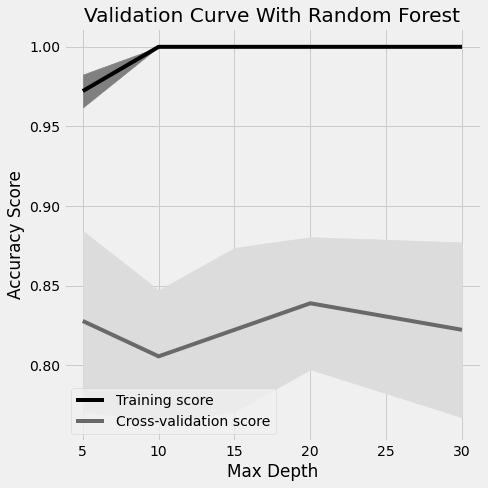

In [32]:
param_range = num_est

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()
# looks like overfitting

# Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix
cm_log = confusion_matrix(y_test,y_predict) #log
cm_forest = confusion_matrix(y_test,y_predict_forest) #forest

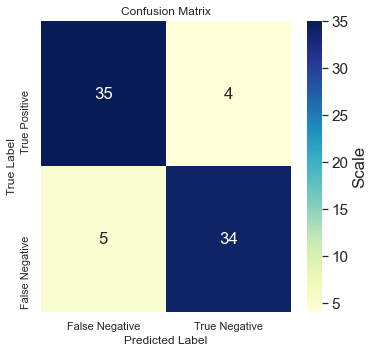

In [34]:
# for log
sns.set(color_codes=True)
plt.figure(1, figsize=(5, 5))
plt.title("Confusion Matrix")
sns.set(font_scale=1.4)
ax = sns.heatmap(cm_log, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
ax.set_xticklabels(['False Negative','True Negative'])
ax.set_yticklabels(['True Positive','False Negative'])
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

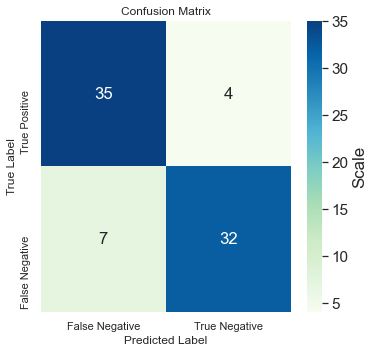

In [35]:
# for forest
sns.set(color_codes=True)
plt.figure(1, figsize=(5, 5))
plt.title("Confusion Matrix")
sns.set(font_scale=1.4)
ax = sns.heatmap(cm_forest, annot=True, cmap="GnBu", cbar_kws={'label': 'Scale'})
ax.set_xticklabels(['False Negative','True Negative'])
ax.set_yticklabels(['True Positive','False Negative'])
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

# Compare Model MSE

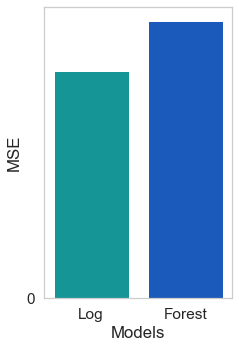

In [36]:
mse_collection = dict()
mse_collection['Log'] = mean_squared_error(y_test, y_predict)
mse_collection['Forest'] = mean_squared_error(y_test,y_predict_forest)

sns.set_style("whitegrid")
plt.figure(figsize=(3,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("MSE")
plt.xlabel("Models")
sns.barplot(x=list(mse_collection.keys()), y=list(mse_collection.values()), palette='winter_r')
plt.show()


# A User's Position in the sample (still under construction)

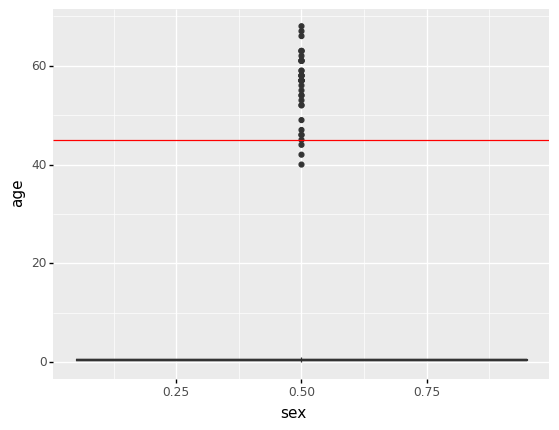

<ggplot: (146023486573)>

In [37]:
# if you want to run this bolck, pip install plotnine
from plotnine import ggplot, aes, geom_hline, geom_boxplot

user_age = 45

(
  ggplot(df_cleaned)
  + aes(x='sex',y='age')
  + geom_boxplot()
  + geom_hline(yintercept=user_age, color = 'red')
)

# ROC Curve

In [38]:
from sklearn import metrics

AUC: 0.8846153846153846


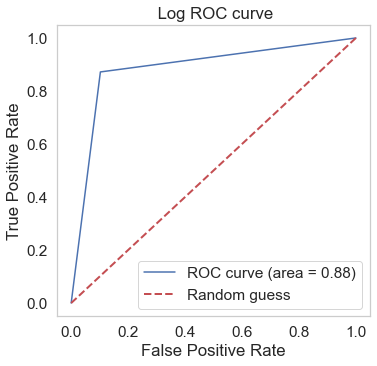

In [39]:
# log
fpr, tpr, thresh = metrics.roc_curve(y_test,y_predict) #log
auc = metrics.auc(fpr, tpr)
print("AUC:", auc)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title(' Log ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

AUC: 0.858974358974359


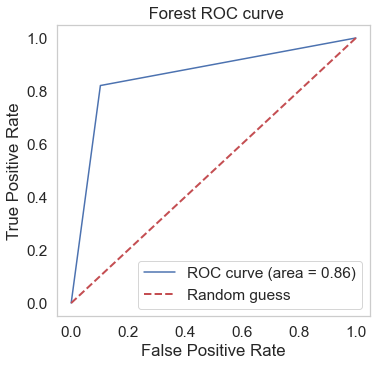

In [40]:
# forest
fpr, tpr, thresh = metrics.roc_curve(y_test,y_predict_forest) #log
auc = metrics.auc(fpr, tpr)
print("AUC:", auc)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title(' Forest ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()